In [1]:
!pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp36-none-any.whl size=19867 sha256=c1303c137bf8f528273ef3cf5247f00bd7a2f63f14b3e40878eef268be369b81
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
n_start_AcqFunc = 629 #multi-start iterations to avoid local optima in AcqFunc optimization

In [4]:
### Data inputs:
set_seed = 888 #initialise pseudo-random number generator, same start-point each time.

### Acquisition / Utility function - MLE/Type II:
d_util = 'dEI_GP'

n_test = n_start_AcqFunc
opt=False

In [5]:
### Objective Function - Sin(x) 1-D:

eps = 1e-8

def f_sine(x1_training):
    return operator * np.sin(x1_training)
        
def f_sine_eps(x1_training):
    return operator * np.sin(x1_training + eps)

# Constraints:
lb = 0
ub = 2 * np.pi
    
# Input array dimension(s):
dim = 1

# 1-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 1 # targets global maximum 
operator = 1 # targets global maximum 
y_global_orig = y_lb * operator # targets global maximum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)

In [6]:
### Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    l = 1
    sigmaf = 1e-4
    sigman = 1e-6

    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (r **2 - 1)
        return d2K
    
cov_func = squaredExponential()
cov_func_hess = squaredExponentialDeriv()

In [7]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, **self.params)

In [9]:
### Surrogate derivatives: 

from scipy.linalg import cholesky, solve

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1e-4
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

In [10]:
class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
        
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [11]:
### d2GPGO - BayesOpt class: Exact Hessian

class d2GPGO(GPGO):  
    n_start = n_start_AcqFunc
    p = np.full((n_start,1),1)*0 + 1
    eps = 1e-08
    
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
    
    def hessp_nonzero(self, xnew, p):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        df2 = np.empty((self.n_start,))
        df2 = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[2]
        H2 = np.empty((self.n_start,))
        df2 = np.asarray(df2)
        p = np.asarray(p)
        H2 = np.multiply(df2,p)
        return H2

    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        d2f = (z * norm.cdf(z) + norm.pdf(z)[0]) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx

        return d2f

    def hessp_nonzero1(self, xnew, p, *args):
      new_mean, new_var = self.GP.predict(xnew, return_std=True)
      new_std = np.sqrt(new_var + 1e-6)
      ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
      df2 = np.empty((self.n_start,))
      df2 = -self.dEI_GP(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0] * p
      return df2

    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,                  
                                                                 hessp = self.hessp_nonzero1,                      
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]

    def run(self, max_iter=10, init_evals=3, resume=False):    
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [12]:
n_init = 5  # Number of iterations used to initialise Bayesian optimisation; minimum 2

In [13]:
np.random.seed(set_seed)

gp_lbfgsb = dGaussianProcess(cov_func_hess, optimize=opt)
gpgo_lbfgsb = dGPGO(gp_lbfgsb, Acquisition_new(d_util), f_sine, param)
gpgo_lbfgsb.run(init_evals=n_init, max_iter=0)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911
init   	 [5.78698499]. 	  -0.4760875534527427 	 0.8593619530727911
init   	 [2.69269954]. 	  0.4339685793492214 	 0.8593619530727911


In [14]:
np.random.seed(set_seed)

gp_ncg = dGaussianProcess(cov_func_hess, optimize=opt)
gpgo_ncg = d2GPGO(gp_ncg, Acquisition_new(d_util), f_sine, param)
gpgo_ncg.run(init_evals=n_init, max_iter=0)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911
init   	 [5.78698499]. 	  -0.4760875534527427 	 0.8593619530727911
init   	 [2.69269954]. 	  0.4339685793492214 	 0.8593619530727911


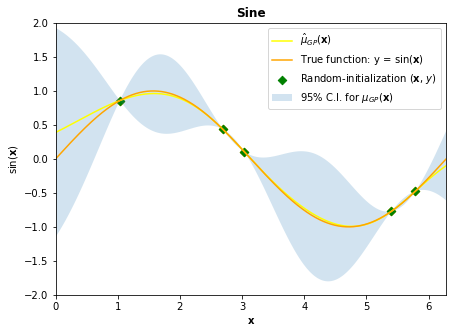

In [15]:
def plot_sine(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std # z-score, 95% confidence (two-tail)
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Orange')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialization ($\mathbf{x}$, $y$)')
        plt.ylim(-2,2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), y_hat, color = 'Yellow', label='$\hat{\mu}_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), np.sin(x_test.flatten()), color = 'Orange', label='True function: y = sin($\mathbf{x}$)')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% C.I. for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$)")
        plt.legend(loc=0)
        plt.show()

plot_sine(gpgo_ncg, param, new=True)

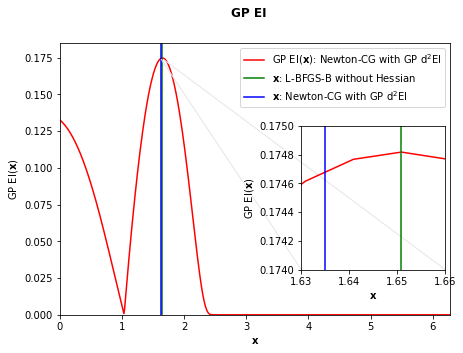

In [16]:
def plot_dGPGO(gpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-gpgo_ncg.func(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a, color='r', label='GP EI$(\mathbf{x})$: Newton-CG with GP d$^{2}$EI')
    plt.ylim(0, 0.185)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(1.6507732807935616, color='g', label='$\mathbf{x}$: L-BFGS-B without Hessian')
    plt.axvline(1.6349952753542698, color='b', label='$\mathbf{x}$: Newton-CG with GP d$^{2}$EI')
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")
    title = 'GP EI'
    plt.suptitle(title, weight = 'bold')

    axins = inset_axes(ax, 2, 2, loc=7, bbox_to_anchor=(0.9, 0.45),bbox_transform=ax.figure.transFigure) # no zoom
    axins.plot(x_test[0:], a[0:], color='r', label='GP EI$(\mathbf{x})$: excl. Hessian')
    axins.set_ylim(0.174, 0.175)
    axins.set_xlim(1.63, 1.66) # Limit the region for zoom
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")
    axins.set_autoscaley_on(True)
    plt.axvline(1.6507732807935613, color='g', label='$\mathbf{x}$: L-BFGS-B without Hessian')
    plt.axvline(1.6349952753542698, color='b', label='$\mathbf{x}$: Newton-CG with GP d$^{2}$EI')
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.9")
    plt.draw()
    plt.show()

plot_dGPGO(gpgo_ncg, param, new=True)

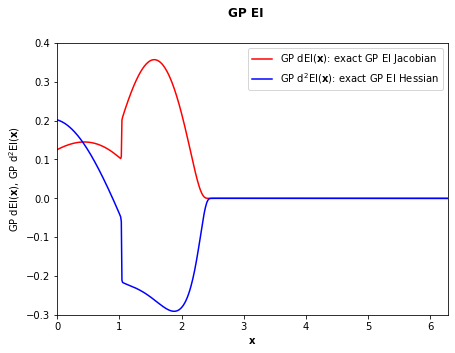

(629, -0.290993752714061, 0.20206889077999377)

In [17]:
def plot_jacobian(gpgo_ncg, param, new):
    plt.figure(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    jac = np.array([-gpgo_ncg.func(np.atleast_1d(x))[1] for x in x_test]).flatten()
    hess = np.array([-gpgo_ncg.hessp_nonzero(np.atleast_1d(x), p=1)[0] for x in x_test]).flatten()
    plt.plot(x_test, jac, color='r', label='GP dEI$(\mathbf{x})$: exact GP EI Jacobian')
    plt.plot(x_test, hess, color='b', label='GP d$^{2}$EI$(\mathbf{x})$: exact GP EI Hessian')
    plt.ylim(-0.3, 0.4)
    plt.xlim(0, 2 * np.pi)
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP dEI$(\mathbf{x})$, GP d$^{2}$EI$(\mathbf{x})$")
    title = 'GP EI'
    plt.suptitle(title, weight = 'bold')    
    plt.show()
    return len(hess), min(hess), max(hess)
  
plot_jacobian(gpgo_ncg, param, new=True)

In [18]:
np.random.seed(set_seed)

gp_lbfgsb = dGaussianProcess(cov_func_hess, optimize=opt)
gpgo_lbfgsb = dGPGO(gp_lbfgsb, Acquisition_new(d_util), f_sine, param)
gpgo_lbfgsb.run(init_evals=n_init, max_iter=1)

x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_lbfgsb = np.array(-gpgo_lbfgsb.f_best.flatten())
max(a_lbfgsb), gpgo_lbfgsb.best[0]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911
init   	 [5.78698499]. 	  -0.4760875534527427 	 0.8593619530727911
init   	 [2.69269954]. 	  0.4339685793492214 	 0.8593619530727911
1      	 [1.65077328]. 	  0.9968035477520534 	 0.9968035477520534


(0.17481749972807062, 1.6507732807935613)

In [19]:
np.random.seed(set_seed)

gp_ncg = dGaussianProcess(cov_func_hess, optimize=opt)
gpgo_ncg = d2GPGO(gp_ncg, Acquisition_new(d_util), f_sine, param)
gpgo_ncg.run(init_evals=n_init, max_iter=1)

x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_ncg = np.array(-gpgo_ncg.f_best.flatten())
max(a_ncg), gpgo_ncg.best[0]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911
init   	 [5.78698499]. 	  -0.4760875534527427 	 0.8593619530727911
init   	 [2.69269954]. 	  0.4339685793492214 	 0.8593619530727911
1      	 [1.63499528]. 	  0.9979399551881812 	 0.9979399551881812


(0.17469108501459668, 1.6349952753542698)

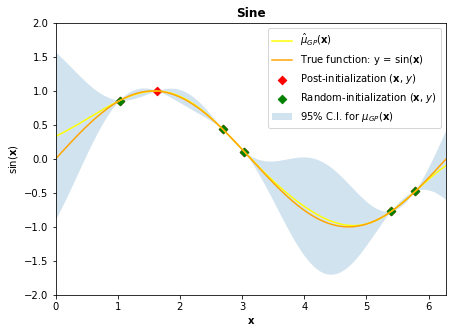

In [20]:
def plot_sine(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std # z-score, 95% confidence (two-tail)
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Post-initialization ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialization ($\mathbf{x}$, $y$)')
        plt.ylim(-2,2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), y_hat, color = 'Yellow', label='$\hat{\mu}_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), np.sin(x_test.flatten()), color = 'Orange', label='True function: y = sin($\mathbf{x}$)')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% C.I. for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$)")
        plt.legend(loc=0)
        plt.show()

plot_sine(gpgo_ncg, param, new=True)

In [21]:
y_global_opt = 1

In [22]:
gpgo_lbfgsb.tau, gpgo_ncg.tau

(0.9968035477520534, 0.9979399551881812)

In [23]:
gpgo_lbfgsb_regret = y_global_opt - gpgo_lbfgsb.tau
gpgo_ncg_regret = y_global_opt - gpgo_ncg.tau

gpgo_lbfgsb_regret, gpgo_ncg_regret

(0.003196452247946624, 0.002060044811818762)